# 0.0 Imports

In [1]:
import warnings
import numpy             as np
import pandas            as pd
import seaborn           as sns
import scipy.stats       as ss
import scikitplot        as skplt
import matplotlib.pyplot as plt

#Connect database
import psycopg2

from IPython.core.display  import HTML
from IPython.display       import Image

from tabulate              import tabulate
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn               import preprocessing as pp
from sklearn               import model_selection as ms
from sklearn               import ensemble as en
from sklearn               import neighbors as nh
from sklearn.linear_model  import LogisticRegression as lr
from xgboost               import XGBClassifier as xgb


/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## 0.1 Helper Functions

In [2]:
# section 1.2
def db_connection(db_host, db_port, db_database, db_user, db_password):
    conn = None
    try:
        conn = psycopg2.connect(
        host = db_host,
        port = db_port,
        database = db_database,
        user = db_user,
        password = db_password,
        )
        print('Conexão do banco de dados PostreSQL bem-sucedida!')
    except OperationalError as e:
        print('Erro {} ocorreu.'.format(e))
    return conn

#Section 3.5.1
def num_metrics(num_attributes):
  #Central tendencian - mean, median

  ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
  ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

  #Dispersion - std, min, max, range, skew, kurtosis

  d1 = pd.DataFrame(num_attributes.apply(np.std)).T
  d2 = pd.DataFrame(num_attributes.apply(min)).T
  d3 = pd.DataFrame(num_attributes.apply(max)).T
  d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
  d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
  d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

  #Concatenate
  metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
  metrics.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
  return metrics

# section 6.3.2 
def cramer_v(x, y):
    '''This functions calculates the Cramér V, a measure of association between two nominal variables'''
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / min(kcorr - 1, rcorr - 1))

  
def jupyter_settings():
    
    %matplotlib inline 
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=[20,10]
    plt.rcParams['font.size']=12
    
    display( HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False )
    
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [3]:
warnings.filterwarnings ('ignore')

# 1.0 Conexão com Banco de Dados


- O módulo psycopg2 permite estabelecer conexão e consultar um banco de dados PostgreSQL e está disponível como um pacote indicador do Linux, macOS ou Windows
- O fetchall () busca todas as linhas no conjunto de resultados e retorna uma lista de tuplas. Se não houver linhas para buscar, o método fetchall () retorna uma lista vazia.

## 1.1 Credentials

In [4]:
Database: Postgres 12.0 AWS
credentials = {'HOST':'', 
               'PORT':'',
               'DB':'', 
               'USER':'', 
               'PASSWORD':''}


## 1.2 Connection with Database

In [5]:
connect_db = db_connection(credentials['HOST'],
                           credentials['PORT'],
                           credentials['DB'],
                           credentials['USER'],
                           credentials['PASSWORD'])


#Create a cursor object
conn = connect_db.cursor()

## 1.3 Exploration Database

In [6]:
#Getting tables name from database
query = "SELECT * FROM information_schema.tables WHERE table_type = 'BASE TABLE' AND table_schema = 'pa004';"

pd.read_sql_query(query,connect_db)

In [7]:
#Exploring database - be more especific
query = '''
SELECT table_schema, table_name FROM information_schema.tables
WHERE table_type= 'BASE TABLE' AND table_schema='pa004' 
'''
pd.read_sql_query(query,connect_db)

In [8]:
query = '''
SELECT column_name, data_type FROM information_schema.columns
WHERE table_name= 'users' 
'''
pd.read_sql_query(query,connect_db)

In [9]:
query = '''
SELECT column_name, data_type FROM information_schema.columns
WHERE table_name= 'vehicle' 
'''
pd.read_sql_query(query,connect_db)

In [10]:
query = '''
SELECT column_name, data_type FROM information_schema.columns
WHERE table_name= 'insurance' 
'''
pd.read_sql_query(query,connect_db)

# 2.0 Loading Dataset

In [11]:
query = '''
  SELECT u.id,
         u.gender,
         u.age,
         u.region_code,
         u.policy_sales_channel,
         v.driving_license,
         v.vehicle_age,
         v.vehicle_damage,
         i.previously_insured,
         i.annual_premium,
         i.vintage,
         i.response
  FROM pa004.users u 
  LEFT JOIN pa004.vehicle v ON (u.id = v.id)
  LEFT JOIN pa004.insurance i ON (u.id = i.id)
'''

df_raw = pd.read_sql(query,connect_db)
conn.close()

In [12]:
df_raw.head()

In [13]:
df_raw.to_csv('../dataset.csv')

In [14]:
df_raw = pd.read_csv('../dataset.csv', low_memory=False, index_col=[0])

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
327121,328150,Male,37,0.0,60.0,1,1-2 Year,No,1,2630.0,169,0
186963,351423,Female,22,47.0,152.0,1,< 1 Year,No,1,35205.0,20,0
155075,95969,Male,26,4.0,154.0,1,< 1 Year,No,1,28339.0,251,0
279538,328189,Male,55,28.0,52.0,1,1-2 Year,Yes,0,36877.0,84,0
172796,237990,Female,24,15.0,152.0,1,< 1 Year,Yes,0,33135.0,255,0


# 3.0 Data Description

In [15]:
df3 = df_raw.copy()

## 3.1 Rename Columns

In [16]:
df3.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

Não é necessário renomear as colunas

## 3.2 Data Dimension

In [17]:
print('Number rows: {}'.format(df3.shape[0]))
print('Number cols: {}'.format(df3.shape[1]))

Number rows: 381109
Number cols: 12


## 3.3 Data Types

In [18]:
df3.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 3.4 Check NA

In [19]:
df3.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

O dataset não possui valores nulos

## 3.5 Descriptive Statistical

In [20]:
#Separate categorical variables from numeric variables
num_attributes = df3.select_dtypes(include = ['int64', 'float64'])
cat_attributes= df3.select_dtypes(include = ['object'])

### 3.5.1 Numerical Attributes

In [21]:
num_metrics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 3.5.2 Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

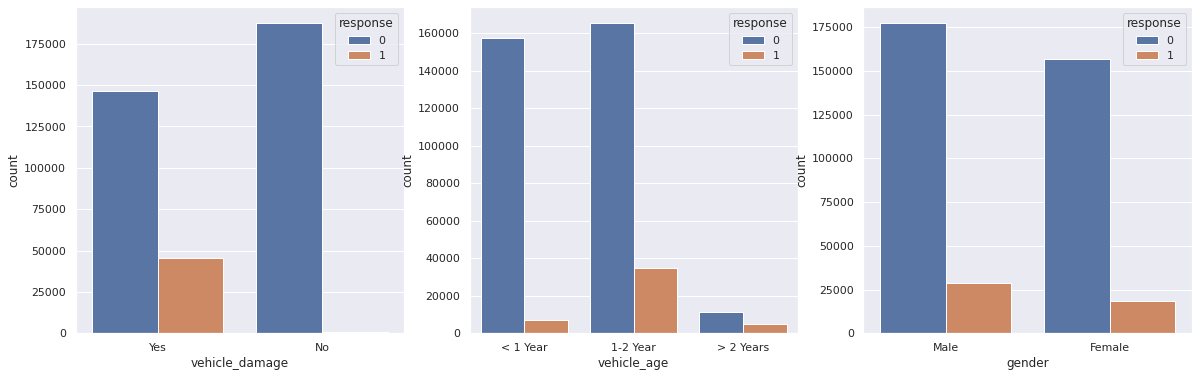

In [23]:
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
sns.countplot(data=df3,x='vehicle_damage',hue='response');

plt.subplot(1, 3, 2)
sns.countplot( data=df3,x='vehicle_age',hue='response');

plt.subplot(1, 3, 3)
sns.countplot(data=df3,x='gender',hue='response');



**Conclusões:**

- A variável age não apresenta valores inconsistentes 
- Pode se perceber na variavel annual_premium que tem uma grande variação nos valores que os clientes pagaram no seguro
- region_code e policy_sales_channel têm skewness negativo, o que significa que as observações estão ligeiramente concentradas no lado direito da distribuição;
- age e year_premium têm uma assimetria positiva baixa, o que significa que as observações estão ligeiramente concentradas no lado esquerdo da distribuição.




# 4.0 - Feature Engineering

## 4.1 Hypothesis Maps

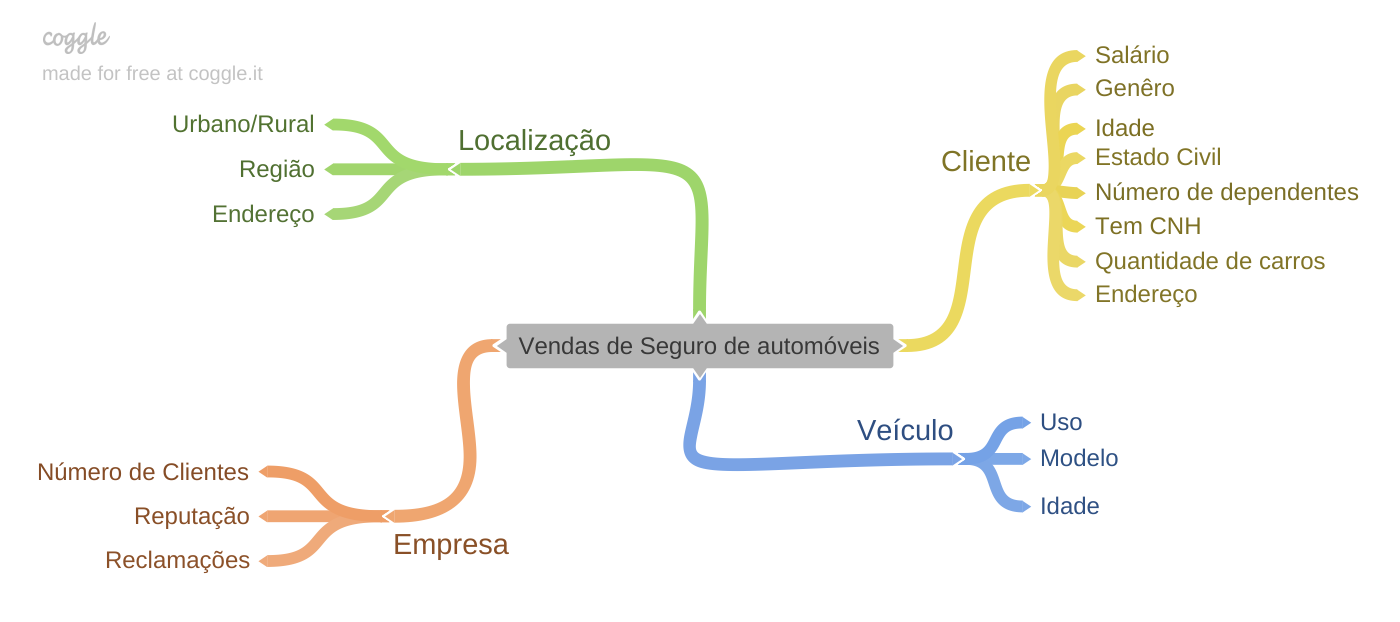

In [24]:
Image('/Seguro_de_automveis.png')

## 4.2 Create Hypothesis 

### 4.2.1  Clientes

- 1. Clientes do genêro masculino contratam mais seguro do que do gênero feminino.
- 2. Clientes com idade maior que 30 anos tem maior interesse em contratar seguro.
- 3. Clientes com carteira de habilitação tem maior interesse em contratar seguro.
- 4. Clientes com histórico ruim de direção tem maior interesse de contratar o seguro.
- 5. Clientes com filhos tem maior interesse em contratar seguro.

### 4.2.2  Veículos

- 1. Clientes com modelos de carros do ano tem maior interesse de contratar seguro.
- 2. Clientes com veículos com um maior uso diário tem maior interesse em contratar seguro.

### 4.2.3  Empresa

- 1. Clientes com seguro saúde tem maior interesse de contratar seguro automovel
- 2. Clientes com menor tempo com o seguro saúde tem menor interesse de contratar seguro automovel

### 4.2.4  Localização

- 1. Clientes que moram em zona rural tem menor interesse de contratar seguro automovel
- 2. Clientes que moram em bairros tem maior interesse de contratar seguro automovel


## 4.3 Final Hypothesis

- 1. Clientes com estado civil casado tem maior interesse de contratar seguros.
- 2. Clientes do genêro masculino contratam mais seguro do que do gênero feminino.
- 3. Clientes com idade maior que 40 anos tem maior interesse em contratar seguro.
- 4. Clientes com filhos tem maior interesse em contratar seguro.
- 5. Clientes com modelos de carros do ano tem maior interesse de contratar seguro.
- 6. Clientes com veículos com um maior uso diário tem maior interesse em contratar seguro.
- 7. Clientes com seguro saúde tem maior interesse de contratar seguro automovel



## 4.4 Feature Engineering

In [25]:
df4 = df3.copy()

In [26]:
# Age
df4['age_range']= df4['age'].apply(lambda y: 'young' if y <= 21 else 'adult' if 21 < y < 60 else 'old' if y >= 60 else 'children') 

# Vehicle Age

df4['vehicle_age']= df4['vehicle_age'].apply(lambda y: 'below_1_year' if y == '< 1 Year' else 'between_1_2_year' if y == '1-2 Year'  else 'over_2_years') 


# Vehicle Damage
vehicle_damage_dict = {'No': 0,
                       'Yes': 1}

df4['vehicle_damage']= df4['vehicle_damage'].map(vehicle_damage_dict)

# Gender
df4['gender_binary']= df4['gender'].apply(lambda y: 0 if y == 'Female' else 1) 


In [27]:
df4.sample(5).T

,66454,218063,110859,98353,328558
id,149647,217236,123025,22241,339950
gender,Male,Female,Male,Male,Female
age,48,44,24,53,24
region_code,28,47,47,41,15
policy_sales_channel,26,124,152,124,152
driving_license,1,1,1,1,1
vehicle_age,between_1_2_year,between_1_2_year,below_1_year,between_1_2_year,below_1_year
vehicle_damage,1,0,1,1,0
previously_insured,0,1,0,0,1
annual_premium,2630,31377,34383,29650,24756


# 5.0 Variable Filtering

In [28]:
df5 = df4.copy()

## 5.1 Rows Filtering

Não vai ser necessário filtrar as linhas deste dataset

## 5.2 Selections Columns

Por enquanto não vai ser necessário selecionar colunas do dataset

# 6.0 Exploratory Analysis

In [29]:
df6 = df5.copy()

In [30]:
num_attributes = df6.select_dtypes(exclude='object')
cat_attributes = df6.select_dtypes(include='object')

## 6.1 Univariate Analysis

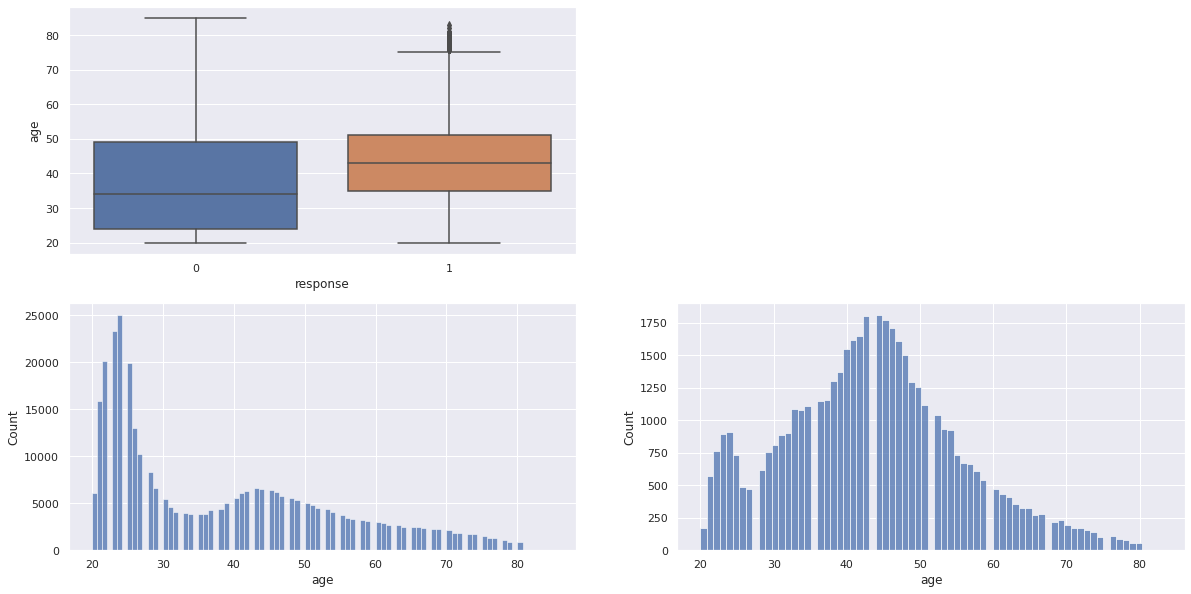

In [31]:
# 'age'
plt.subplot(2,2,1)
sns.boxplot(x='response',y='age',data=df6)

plt.subplot(2,2,3)
aux01 = df6.loc[df6['response'] == 0, 'age']
sns.histplot(aux01)

plt.subplot(2,2,4)
aux02 = df5.loc[df5['response'] == 1, 'age']
sns.histplot(aux02)

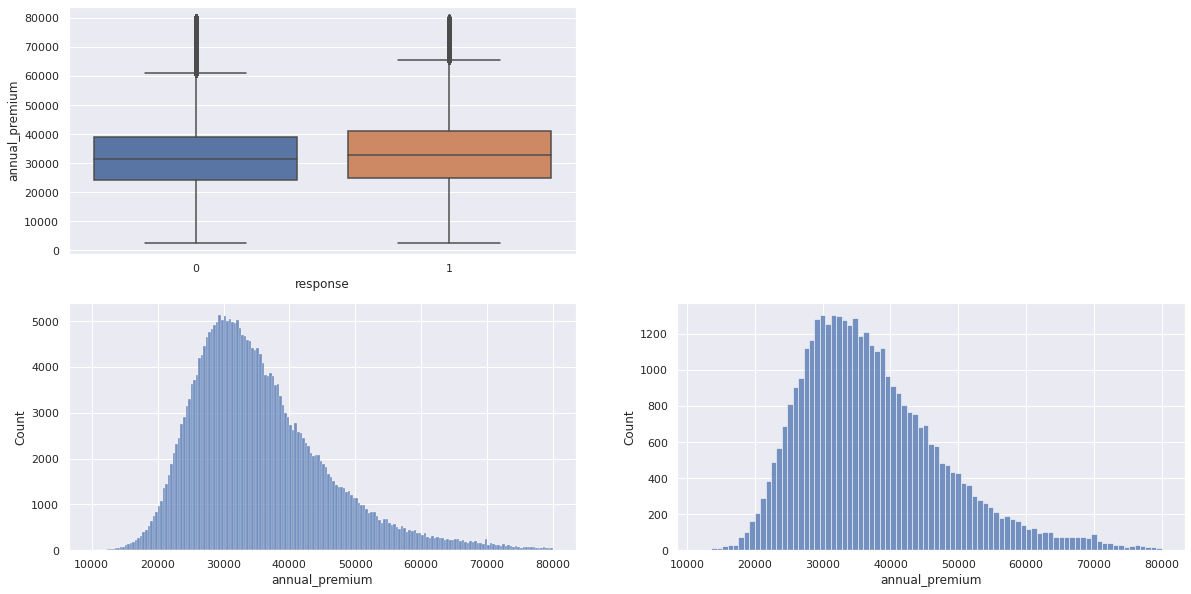

In [32]:
#'annual_premium'
plt.subplot(2,2,1)
aux03 = df6[df6['annual_premium'] < 80000]
sns.boxplot(x='response',y='annual_premium',data=aux03);

plt.subplot(2,2,3)
aux = df6[(df6['annual_premium'] > 10000) & (df6['annual_premium'] < 80000)]
aux01 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux01);

plt.subplot(2,2,4)
aux02 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux02);

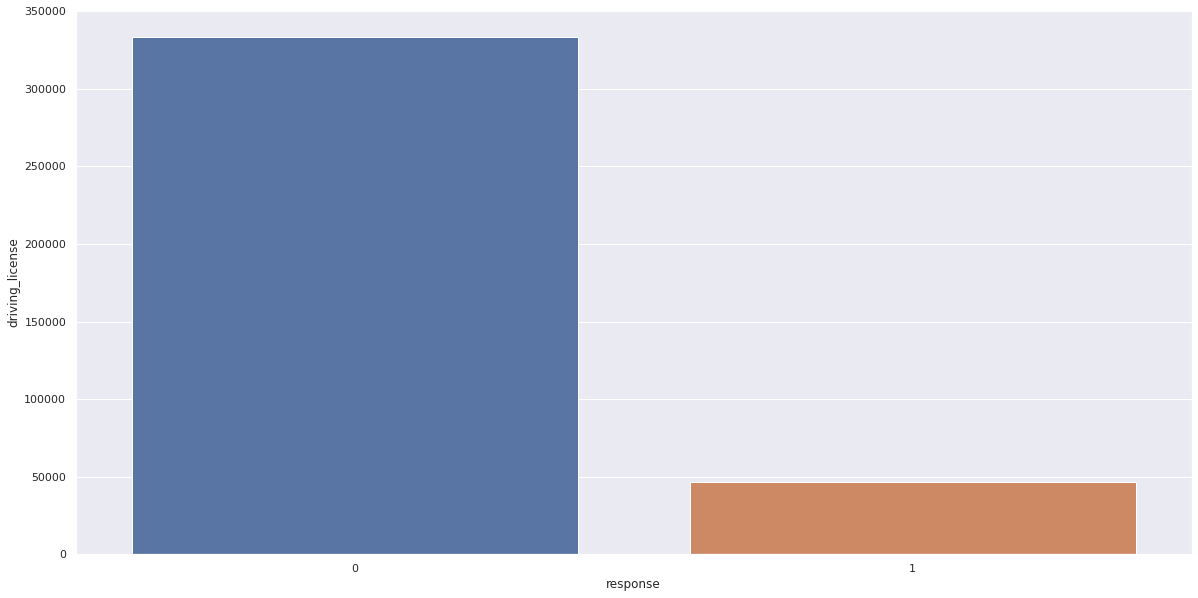

In [33]:
#'driving_license'
aux = df6[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response',y='driving_license',data=aux);

In [34]:
aux['driving_license_perc']= np.round(aux['driving_license']/ aux['driving_license'].sum(), 3) * 100 
aux

,response,driving_license,driving_license_perc
0,0,333628,87.7
1,1,46669,12.3


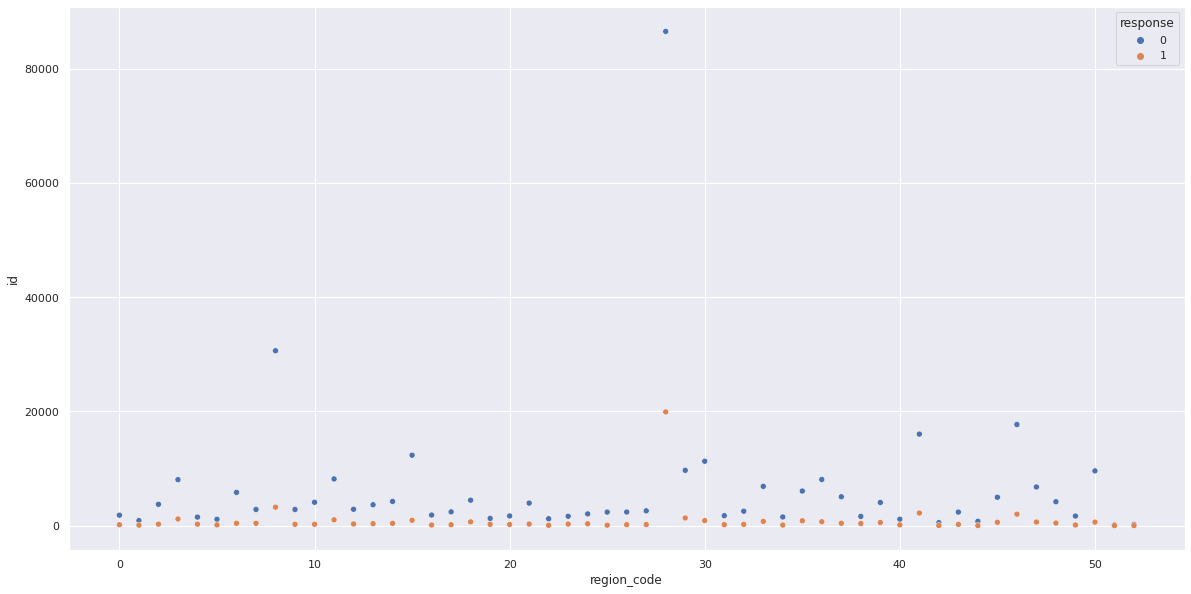

In [35]:
#'region_code'
aux = df6[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
sns.scatterplot(x='region_code',y='id',hue='response', data=aux);

In [36]:
#'previously_insured'
pd.crosstab(df6['previously_insured'],df6['response']).apply(lambda x: x/ x.sum(),axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [37]:
#'vehicle_age'
aux = df6[['id','vehicle_age','response']].groupby(['vehicle_age','response']).count().reset_index()
aux

,vehicle_age,response,id
0,below_1_year,0,157584
1,below_1_year,1,7202
2,between_1_2_year,0,165510
3,between_1_2_year,1,34806
4,over_2_years,0,11305
5,over_2_years,1,4702


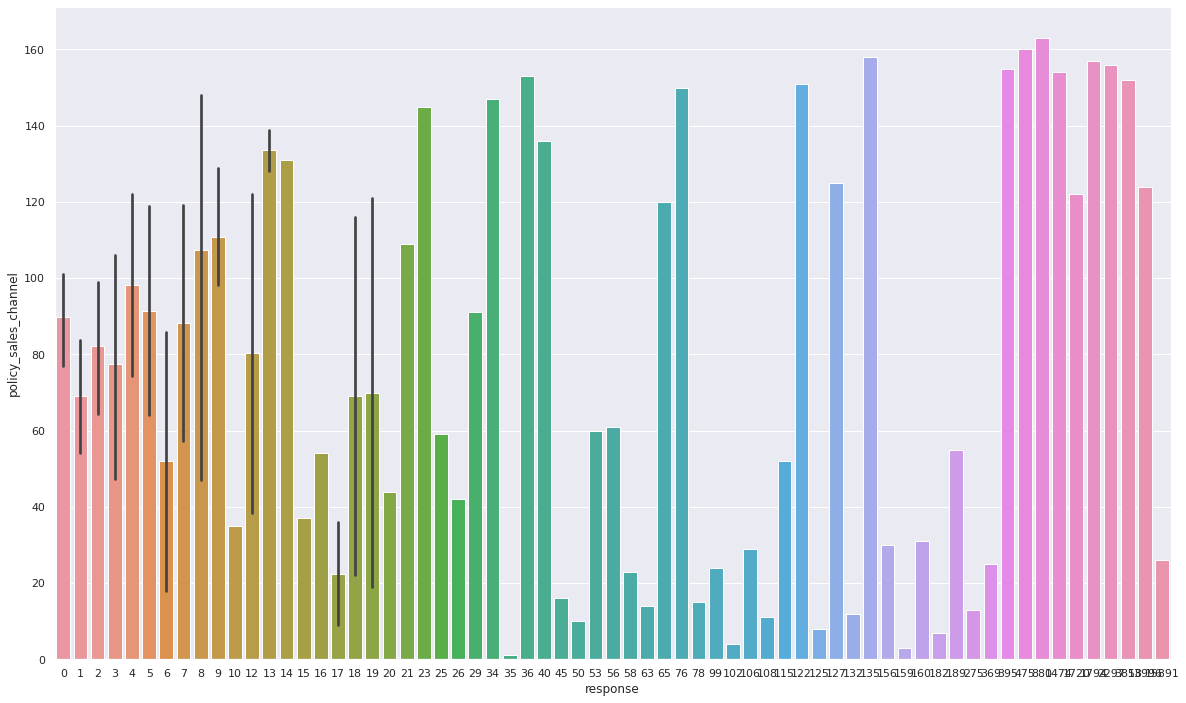

In [38]:
#'policy_sales_channel'
plt.figure(figsize=(20,12))
aux = df6[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response',y='policy_sales_channel', data=aux);

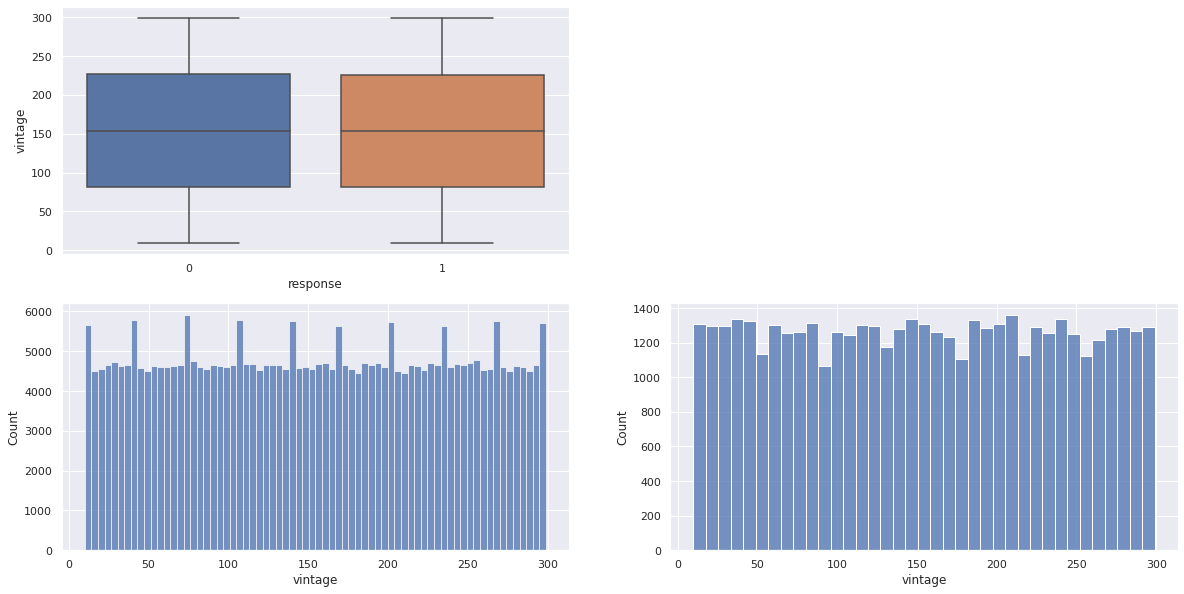

In [39]:
#'vintage'
plt.subplot(2,2,1)
sns.boxplot(x='response',y='vintage',data=df6);

plt.subplot(2,2,3)

aux01 = df6.loc[df6['response'] == 0, 'vintage']
sns.histplot(aux01);

plt.subplot(2,2,4)
aux02 = df6.loc[df6['response'] == 1, 'vintage']
sns.histplot(aux02);

In [40]:
# 'gender'

In [41]:
#'vehicle_damage'

In [42]:
#'age_range'

### 6.1.1 Response Variable

In [43]:
df6['response'].value_counts()

0    334399
1     46710
Name: response, dtype: int64

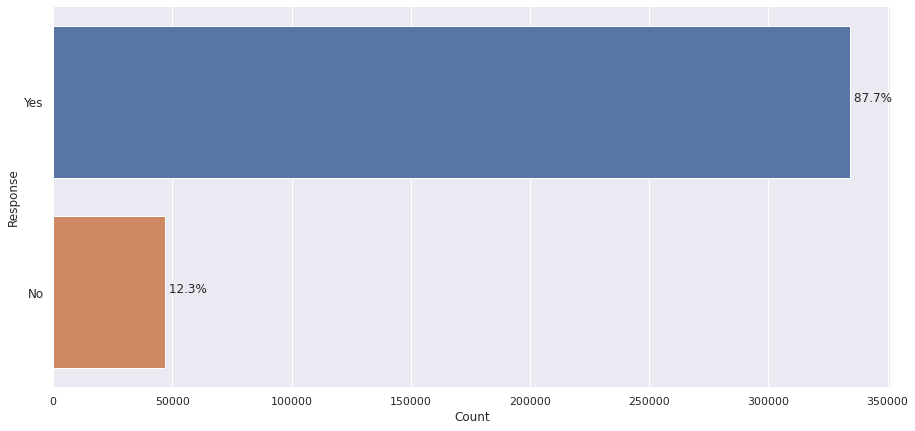

In [44]:
plt.figure(figsize=(15,7))
aux = sns.countplot(y='response', data=df6);
sns.set_style('whitegrid')
plt.xlabel('Count')
plt.ylabel('Response')
plt.yticks(np.arange(2),['Yes','No'], size=12)
sns.despine( bottom=True, left=True)


total = df3['response'].size

for p in aux.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        aux.annotate(percentage, (x, y))

### 6.1.2 Numerical Variable

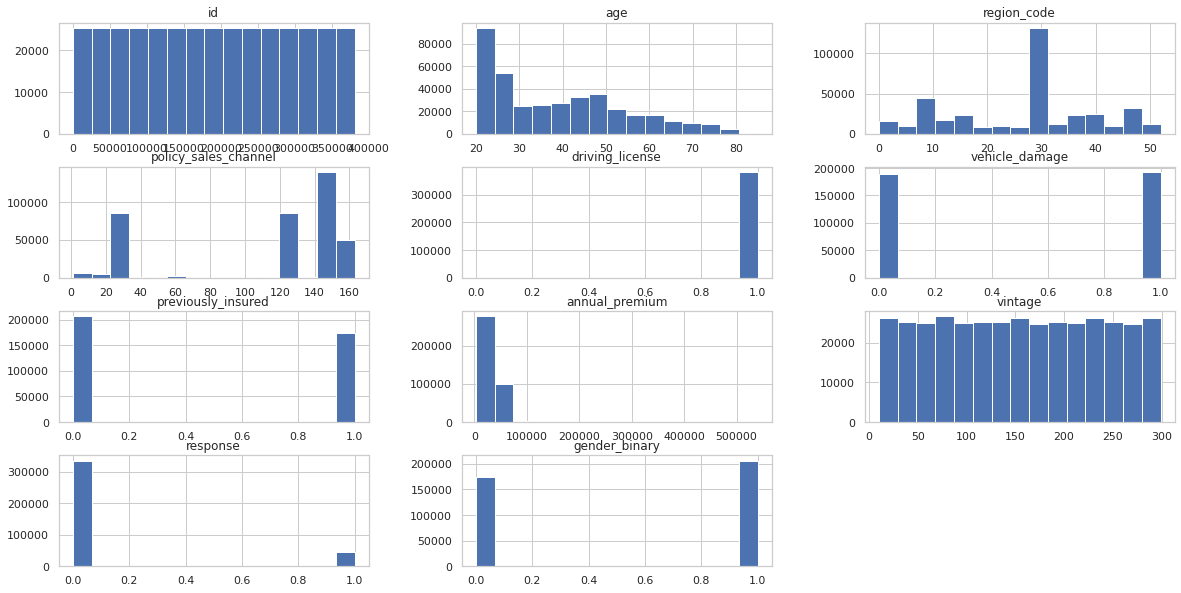

In [45]:
num_attributes.hist(bins=15,figsize=(20,10));

### 6.1.3 Categorical Variable

In [46]:
cat_attributes.describe()

,gender,vehicle_age,age_range
count,381109,381109,381109
unique,2,3,3
top,Male,between_1_2_year,adult
freq,206089,200316,311647


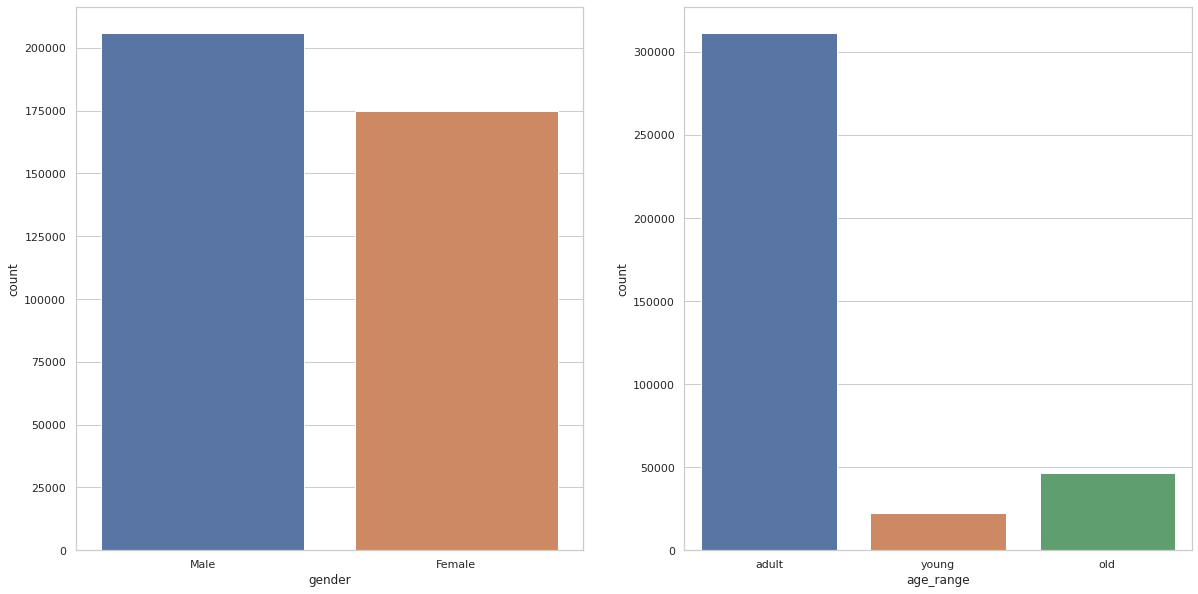

In [47]:
plt.subplots( figsize = ( 20,10 ))

plt.subplot(1, 2, 1);
sns.countplot(cat_attributes['gender']);

plt.subplot(1, 2, 2);
sns.countplot(cat_attributes['age_range']);

## 6.2 Bivariate Analysis

In [48]:
df6.head(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,age_range,gender_binary
0,7,Male,23,11.0,152.0,1,below_1_year,1,0,23367.0,249,0,adult,1
1,13,Female,41,15.0,14.0,1,between_1_2_year,0,1,31409.0,221,0,adult,0
2,18,Female,25,35.0,152.0,1,below_1_year,0,1,46622.0,299,0,adult,0
3,31,Female,26,8.0,160.0,1,below_1_year,0,0,2630.0,136,0,adult,0
4,39,Male,45,8.0,124.0,1,between_1_2_year,1,0,42297.0,264,0,adult,1


### H1. Clientes do genêro masculino contratam mais seguro do que do gênero feminino.


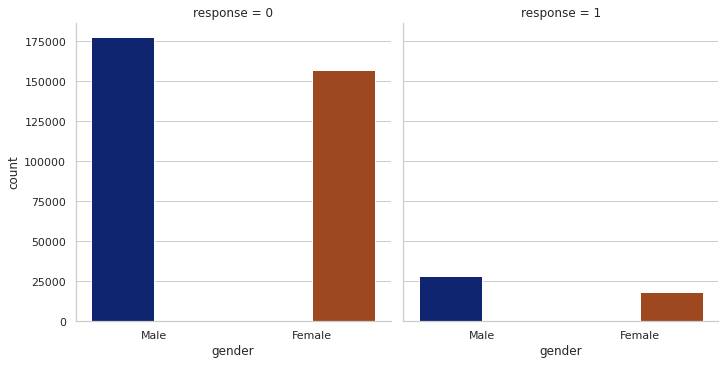

In [49]:
sns.catplot(data=df6, kind="count",x="gender",  col="response", hue="gender", palette="dark");

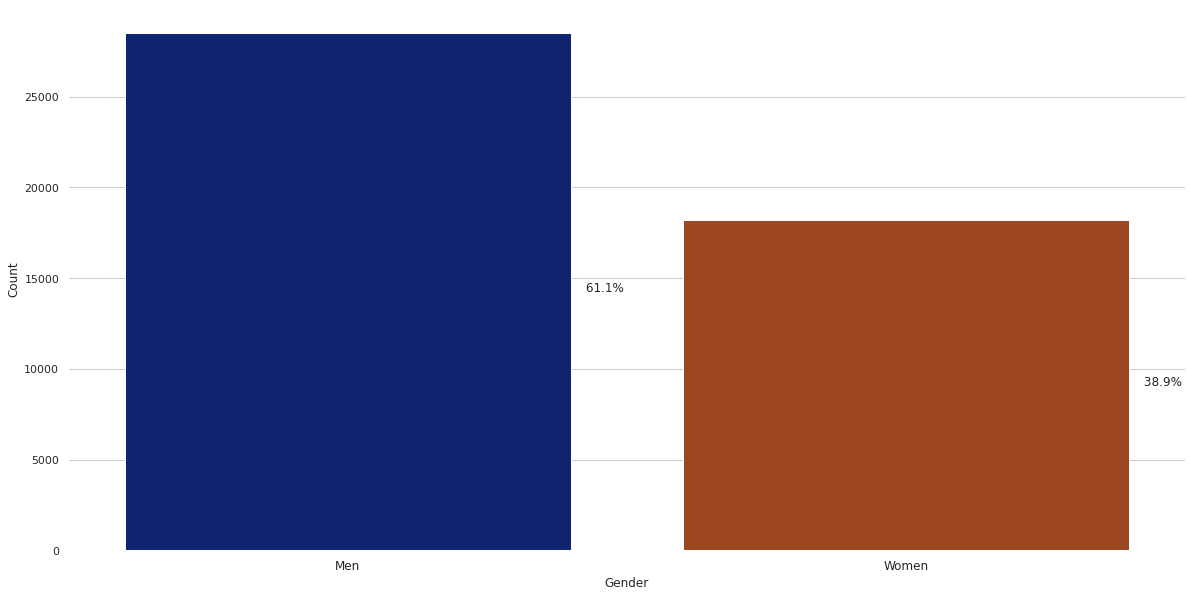

In [50]:
aux  = df6[df6['response']== 1]

ax = sns.countplot(x='gender', data=aux,palette='dark');
plt.xticks(np.arange(2),['Men','Women'], size=12)
plt.xlabel('Gender')
plt.ylabel('Count')
sns.despine( bottom=True, left=True)

total = aux['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H2. Clientes com idade maior que 40 anos tem maior interesse em contratar seguro.


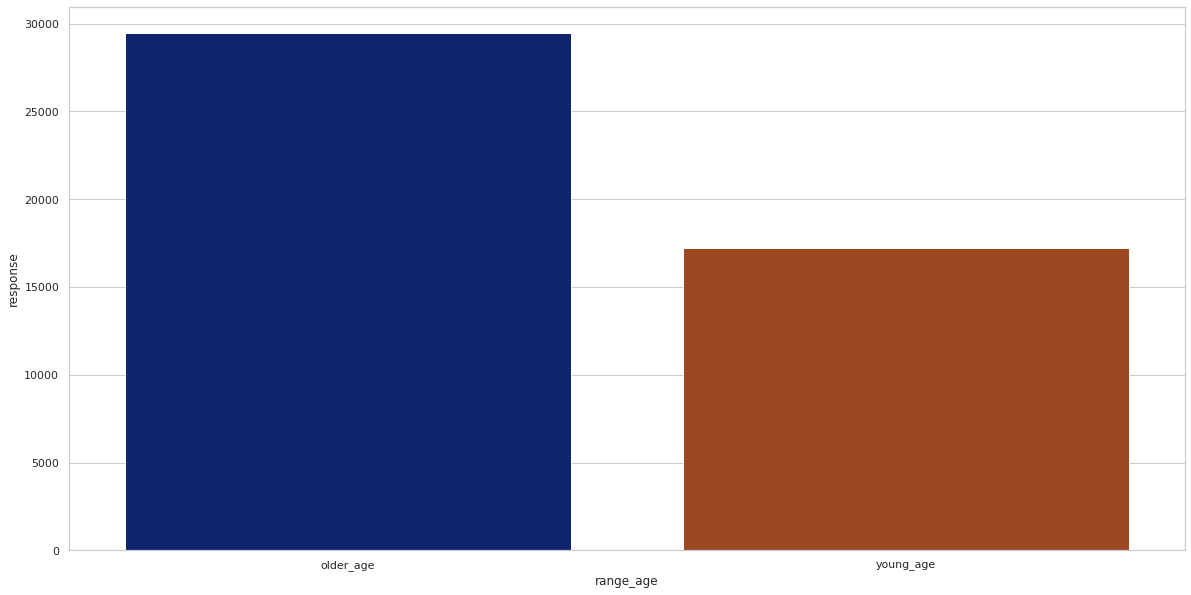

In [51]:
plt.figure(figsize=(20,10))

aux1 = df6[['age','response']].groupby('age').sum().reset_index()

aux1['range_age'] = aux1['age'].apply(lambda x: 'young_age' if x < 40 else 'older_age')
aux2 = aux1[['range_age', 'response']].groupby('range_age').sum().reset_index()

ax = sns.barplot(x='range_age', y='response', data= aux2,palette='dark');


### H3. Clientes com carteira de habilitação tem maior interesse em contratar seguro



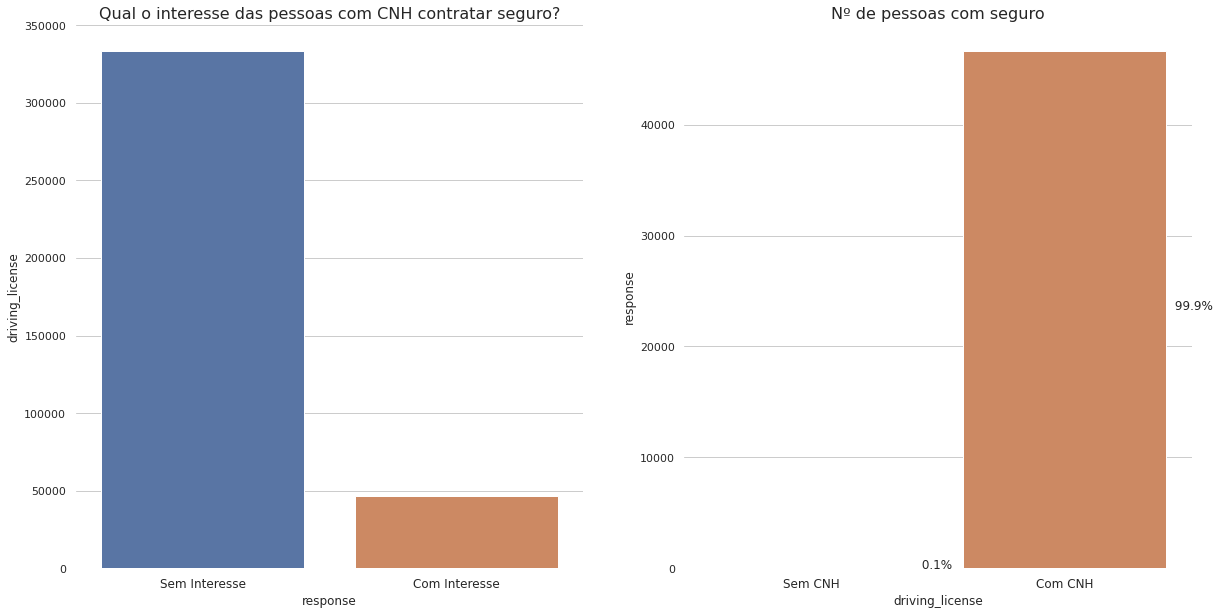

In [52]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
aux01= df6[df6['driving_license']==1]
aux02= aux01[['response','driving_license']].groupby('response').sum().reset_index()

#plotando o gráfico
ax1 = sns.barplot(x='response', y='driving_license', data= aux02);
plt.title('Qual o interesse das pessoas com CNH contratar seguro?', size = 16)
plt.xticks(np.arange(2), ['Sem Interesse', 'Com Interesse'], size = 12)

sns.despine( bottom=True, left=True)

plt.subplot(1,2,2)
aux03= df6[df6['response']== 1]
aux04= aux03[['response','driving_license']].groupby('driving_license').sum().reset_index()

#plotando o gráfico
ax = sns.barplot(x='driving_license', y='response', data= aux04);
plt.title('Nº de pessoas com seguro', size = 16)
plt.xticks(np.arange(2), ['Sem CNH', 'Com CNH'], size = 12)

sns.despine( bottom=True, left=True)

total01 = aux03['driving_license'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_height()/total01)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))


### H4. Clientes com carros mais novos tem maior interesse de contratar seguro.


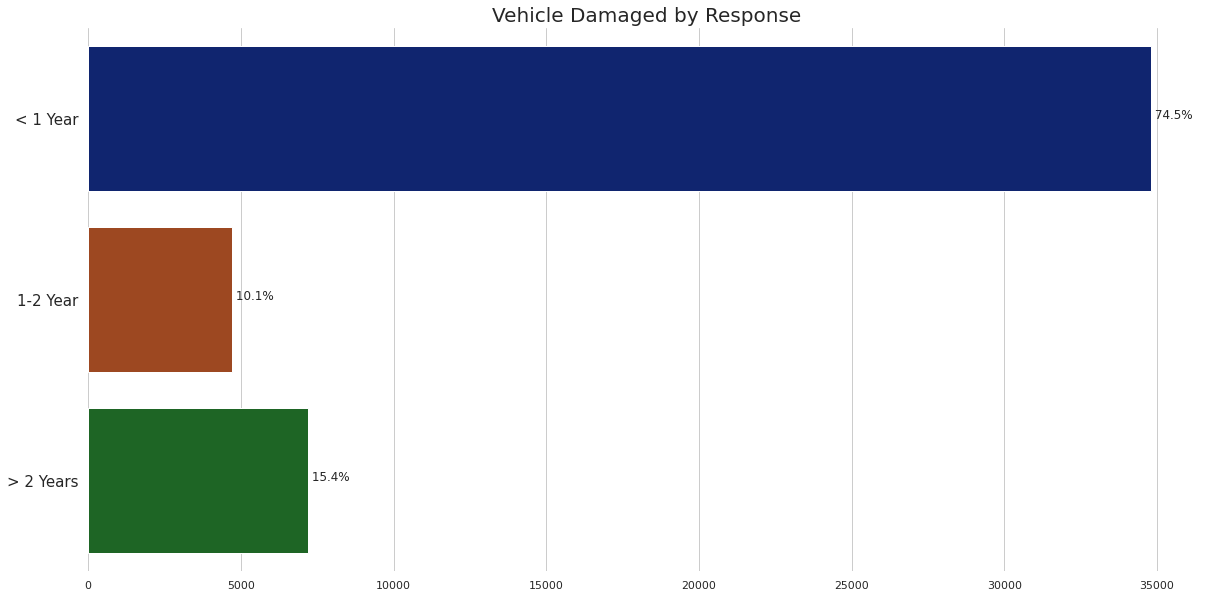

In [53]:
aux01= df6[df6['response']== 1]

ax = sns.countplot(y='vehicle_age',data=aux01,palette='dark');

plt.title('Vehicle Damaged by Response', size = 20)
plt.yticks(np.arange(3), ['< 1 Year', '1-2 Year','> 2 Years'], size = 15)

plt.xlabel('', color='white')
plt.ylabel('', color='white');
sns.despine( bottom=True, left=True)

total = aux01['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))




### H5. Clientes com veículos danificados anteriormente tem maior interesse de contratar seguro.

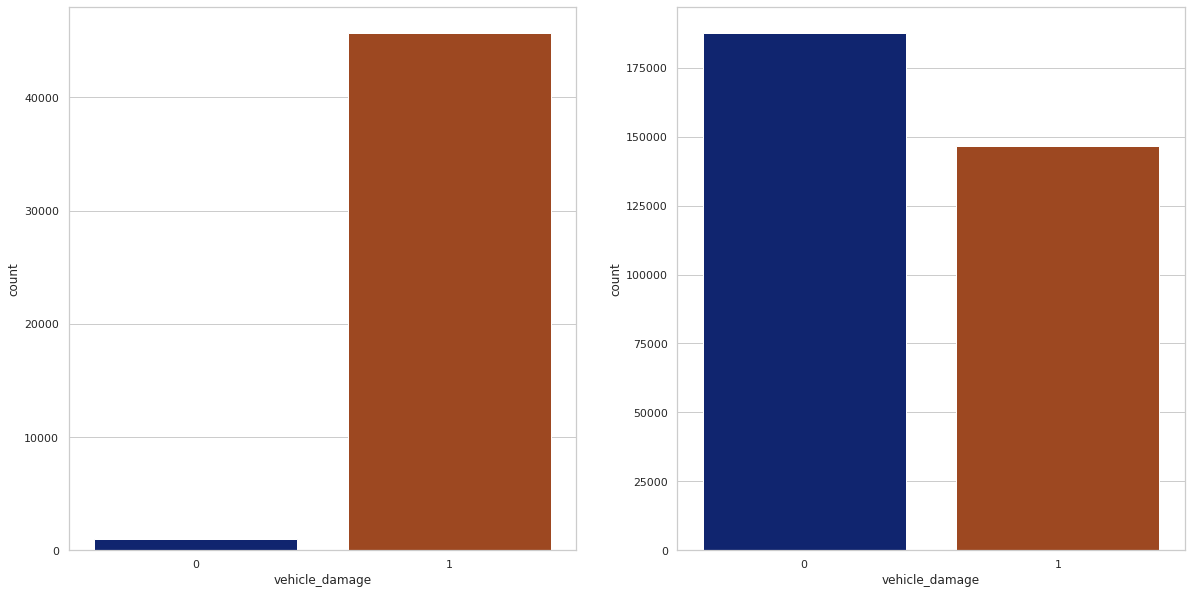

In [54]:
plt.subplot(1,2,1)
aux01 = df6[df6['response'] == 1]

sns.countplot(x='vehicle_damage',data=aux01,palette='dark');



plt.subplot(1,2,2)
aux02 = df5[df5['response'] == 0]

sns.countplot(x='vehicle_damage',data=aux02,palette='dark');



### H7. Clientes com seguro automóvel a mais tempo tem maior interesse de contratar.

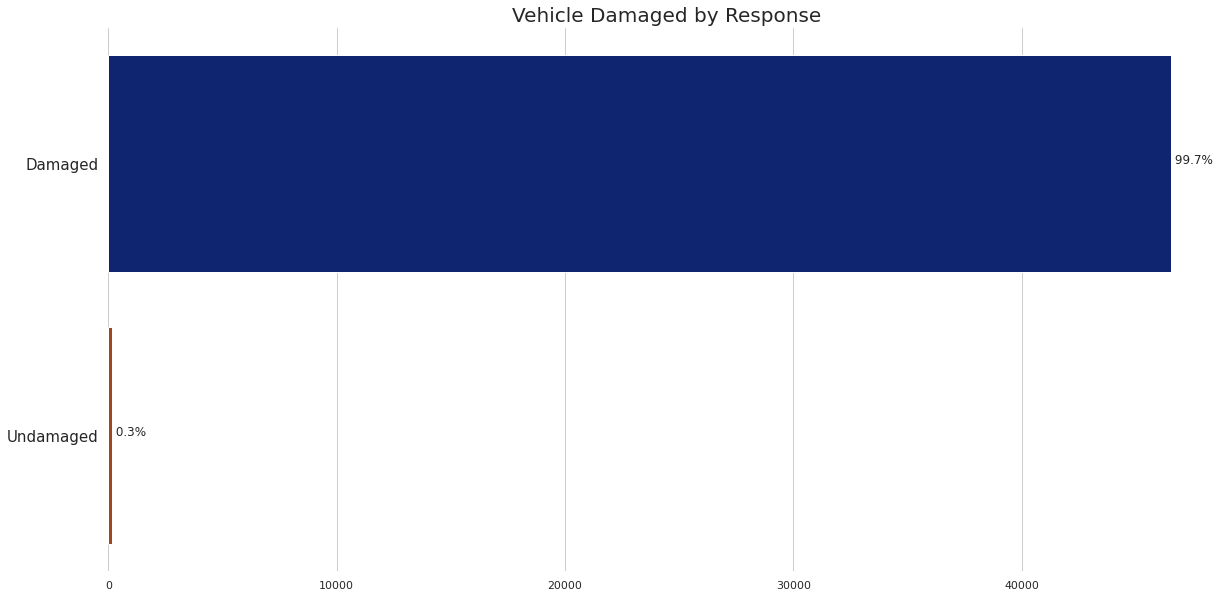

In [55]:
aux01 = df6[df6['response'] == 1]

ax = sns.countplot(y='previously_insured',data=aux01,palette='dark');

sns.set_style('whitegrid')
plt.title('Vehicle Damaged by Response', size = 20)
plt.yticks(np.arange(2), ['Damaged', 'Undamaged'], size = 15)

plt.xlabel('', color='white')
plt.ylabel('', color='white');
sns.despine( bottom=True, left=True)

total = aux01['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))



### 6.2.1 Final Hypothesis

In [56]:
tab =[['Hypotheses', 'Conclusion'],
       ['H1','---'],
       ['H2','---'],
       ['H3','---'],
       ['H4','---'],
       ['H5','---'],
       ['H6','---'],
       ['H7','---']
] 

print(tabulate(tab, headers='firstrow'))

Hypotheses    Conclusion
------------  ------------
H1            ---
H2            ---
H3            ---
H4            ---
H5            ---
H6            ---
H7            ---


## 6.3 Multivariate Analisys

### 6.3.1 Numerical Attributes

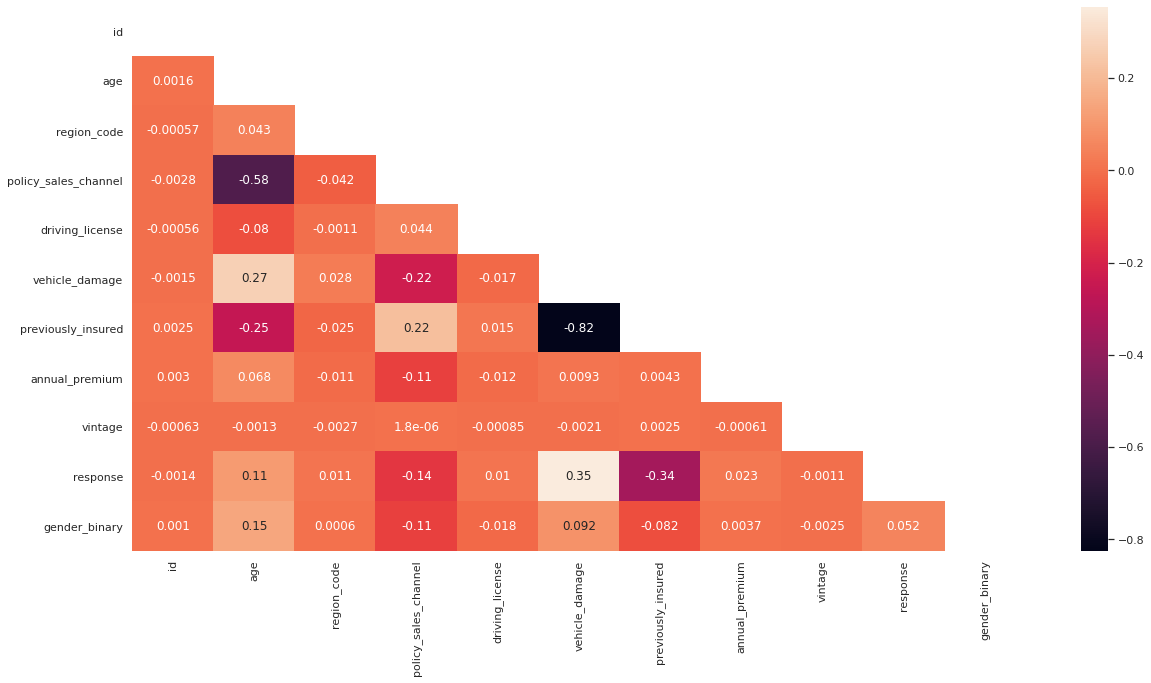

In [57]:
correlation = num_attributes.corr(method='pearson')

# Creating a with mask for the superior triangle
ax = np.zeros_like(correlation)
ax[np.triu_indices_from(ax)] = True


sns.heatmap(correlation,mask=ax, annot=True);

### 6.3.2 Categorical Attributes

In [58]:
a = df5.select_dtypes(include='object')
a.columns

Index(['gender', 'vehicle_age', 'age_range'], dtype='object')

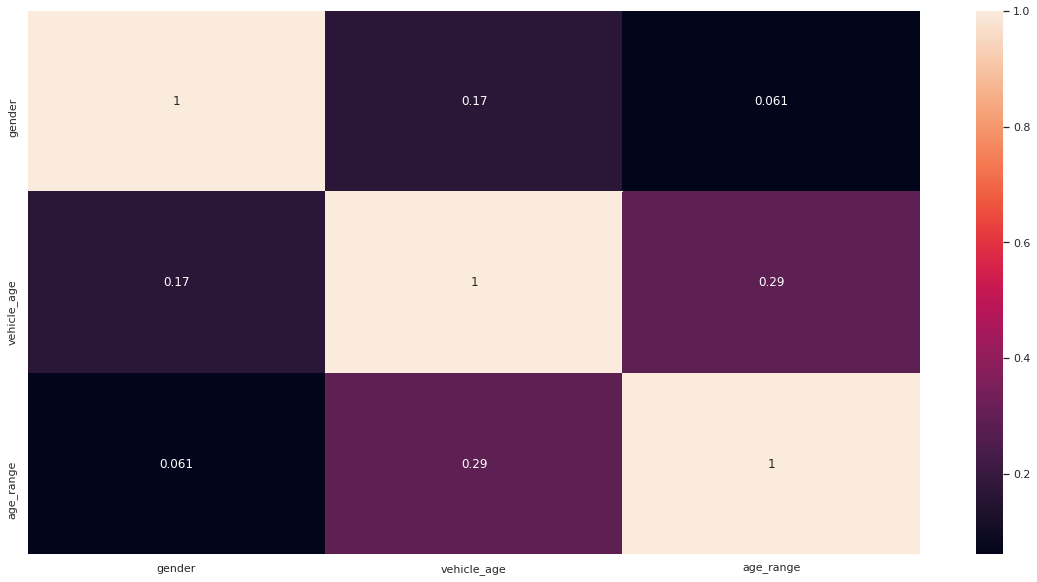

In [59]:

# only categorical data
a = df5.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])
a3 = cramer_v(a['gender'], a['age_range'])

a4 = cramer_v(a['vehicle_age'], a['gender'])
a5 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a6 = cramer_v(a['vehicle_age'], a['age_range'])

a7 = cramer_v(a['age_range'], a['gender'])
a8 = cramer_v(a['age_range'], a['vehicle_age'])
a9 = cramer_v(a['age_range'], a['age_range'])

#Final Dataset

data = pd.DataFrame({'gender':[a1,a2,a3],
                     'vehicle_age':[a4,a5,a6],
                     'age_range':[a7,a8,a9]})

data = data.set_index(data.columns)
sns.heatmap(data,annot=True);

# 7.0 Data Preparation

In [60]:
df7 = df6.copy()

In [61]:
X =  df7.drop('response',axis=1)
y = df7['response'].copy()

x_train, x_val,y_train,y_val = ms.train_test_split(X, y, test_size=0.20)

df7 = pd.concat([x_train,y_train], axis=1) 

## 7.1  Rescaling

In [62]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

In [63]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#age
df7['age'] = mms_age.fit_transform( df7[['age']].values )

#vintage
df7['vintage'] = mms_vintage.fit_transform(df7[['vintage']].values )

## 7.2 Encoding

In [64]:
#gender
target_encode_gender = df7.groupby('gender')['response'].mean()
df7.loc[:,'gender']= df7['gender'].map(target_encode_gender)

#region_code
target_encode_region_code = df7.groupby('region_code')['response'].mean()
df7.loc[:,'region_code']= df7['region_code'].map(target_encode_region_code)

#vehicle_age
df7 = pd.get_dummies(df7,prefix='vehicle_age',columns=['vehicle_age'])

#policy_sales_channel
fe_policy_sales_channel = df7.groupby('policy_sales_channel').size() / len(df7)
df7.loc[:,'policy_sales_channel']= df7['policy_sales_channel'].map(fe_policy_sales_channel)



# 7.3 Standardization

In [65]:
ss = pp.StandardScaler()

In [66]:
df7['annual_premium'] = ss.fit_transform( df7[['annual_premium']].values )

# 7.4 Validation Preparation

In [67]:
#gender
x_val.loc[:,'gender'] = x_val.loc[:,'gender'].map(target_encode_gender)

#age
x_val.loc[:,'age'] = mms_age.transform(x_val[['age']].values)

# region_code
x_val.loc[:,'region_code'] = x_val.loc[:,'region_code'].map(target_encode_region_code)

#vehicle_age
x_val = pd.get_dummies(x_val,prefix='vehicle_age',columns=['vehicle_age'])

#annual_premium
x_val['annual_premium'] = ss.fit_transform( x_val[['annual_premium']].values )

#policy_sales_channel
x_val.loc[:,'policy_sales_channel']= x_val['policy_sales_channel'].map(fe_policy_sales_channel)

#vintage
x_val['vintage'] = mms_vintage.fit_transform(x_val[['vintage']].values )

#fillna
x_val = x_val.fillna(0)

# 8.0 Features Selection

## 8.1 Feature Importance

In [68]:
#definição do modelo
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# Preparação dos Dados
x_train_n = df7.drop(['id','response','age_range'],axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
                     oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

Feature Ranking:
                        feature  importance
0                       vintage    0.272157
0                annual_premium    0.244020
0                           age    0.169161
0                   region_code    0.106125
0                vehicle_damage    0.075396
0          policy_sales_channel    0.059859
0            previously_insured    0.048846
0      vehicle_age_below_1_year    0.012982
0  vehicle_age_between_1_2_year    0.006740
0      vehicle_age_over_2_years    0.002489
0                 gender_binary    0.000890
0                        gender    0.000847
0               driving_license    0.000487


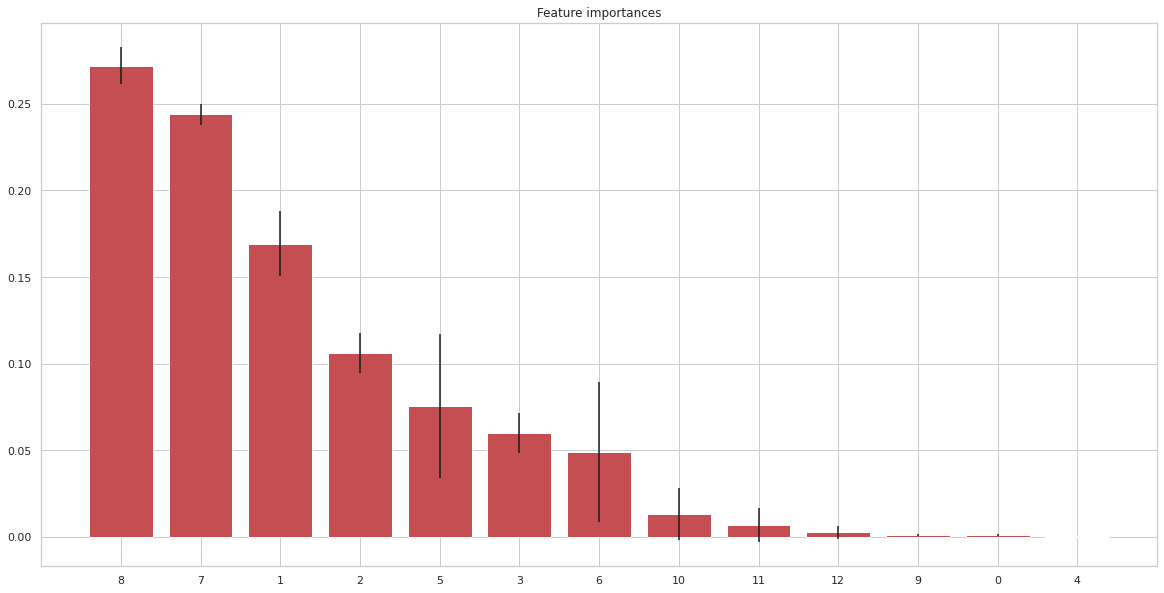

In [69]:
importance = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importance)[::-1]

#Print the feature ranking
print('Feature Ranking:')
df = pd.DataFrame()

for i,j in zip(x_train_n,forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance':j}, index=[0])
    df = pd.concat([df,aux], axis=0)

print(df.sort_values('importance',ascending=False))

#Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train_n.shape[1]),importance[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show();

# 9.0 Machine Learning

In [70]:
cols_selected =['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

x_train = df7[cols_selected]
x_val = x_val[cols_selected]

## 9.1 KNN

In [71]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train,y_train)

# model prediction
yhat_knn = knn_model.predict_proba(x_val)

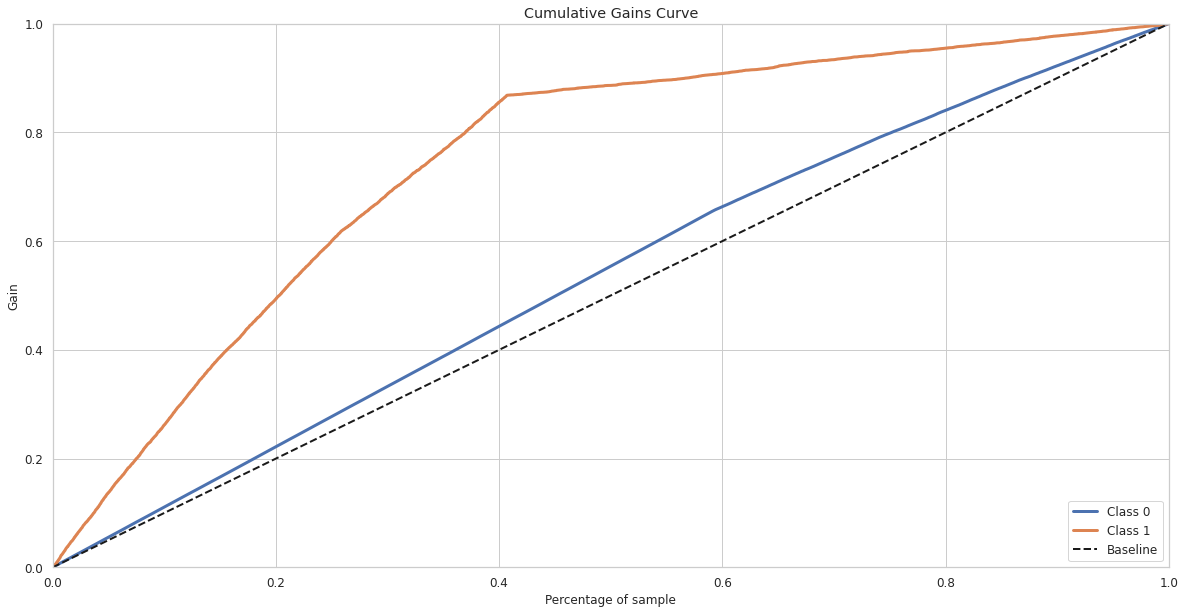

In [72]:
#Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn);

## 9.2 Logistic Regression

In [73]:
# model definition
lr_model = lr(random_state=42)

# model training
lr_model.fit(x_train,y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

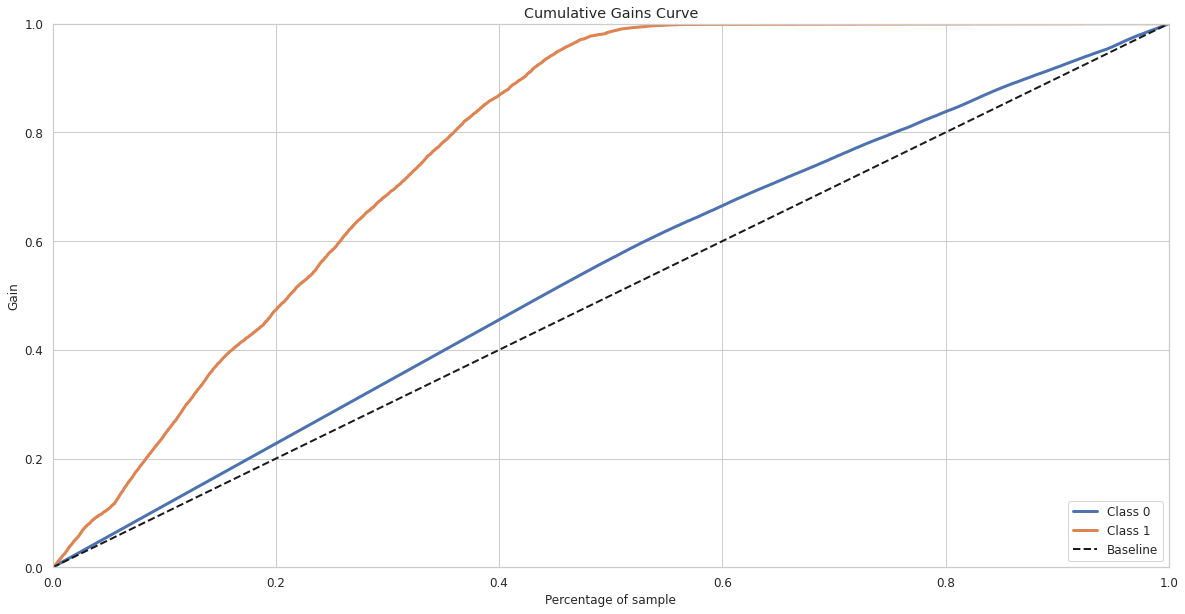

In [74]:
#Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_lr);

## 9.3 XGBoost Classifier

In [75]:
# model definition
xg_model = xgb(n_estimators=7,random_state=42)

# model training
xg_model.fit(x_train,y_train)

# model prediction
yhat_xg = xg_model.predict_proba(x_val)

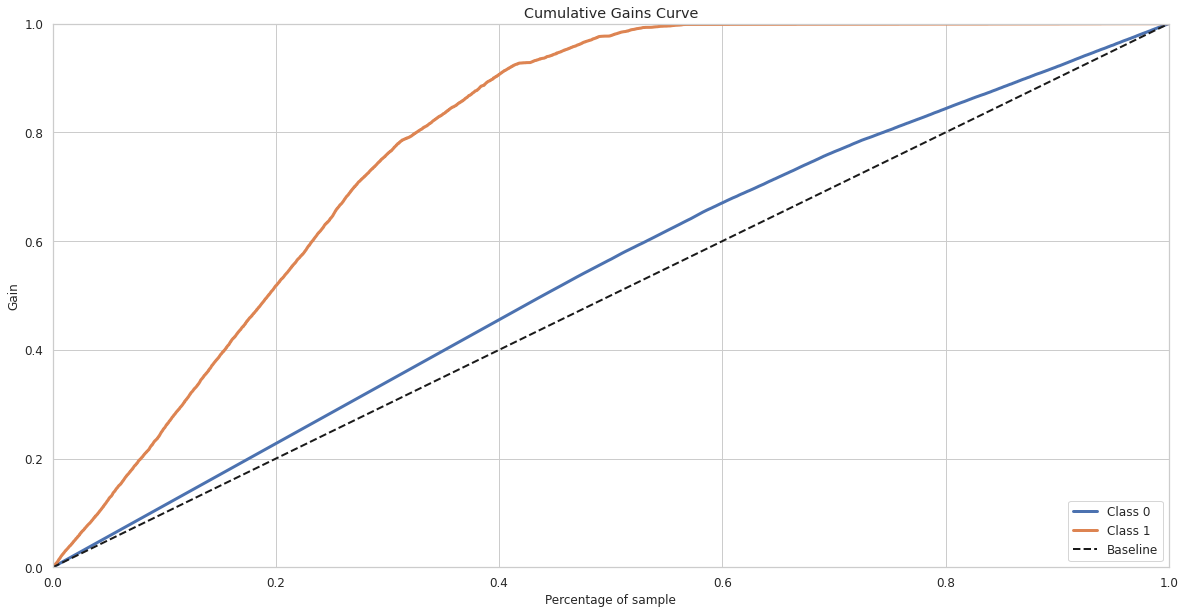

In [76]:
#Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_xg);